<a href="https://colab.research.google.com/github/pranavkairon/QC-mentorship-TASKS/blob/master/mcqst_h2_all_bond_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit
!pip install qiskit[nature]
!pip install pyscf

     |████████████████████████████████| 6.0MB 32.6MB/s 
     |████████████████████████████████| 18.0MB 171kB/s 
     |████████████████████████████████| 235kB 43.9MB/s 
     |████████████████████████████████| 215kB 34.8MB/s 
     |████████████████████████████████| 2.1MB 29.9MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 1.5MB 30.2MB/s 
     |████████████████████████████████| 194kB 33.6MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 614kB 34.2MB/s 
     |████████████████████████████████| 3.2MB 31.1MB/s 
     |████████████████████████████████| 6.3MB 34.7MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=51d833ae337f49a5336d51dff8336dc688fdc4df91ae1b7de2c70cb9394171f7
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-p

In [2]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer,ActiveSpaceTransformer
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
backend = Aer.get_backend('statevector_simulator')
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit.opflow import TwoQubitReduction
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule



In [35]:
exact_energies=[]
vqe_energies=[]


In [36]:
for i in range(0,10):

  bondl=0.1+i*0.1
  molecule = "H .0 .0 .0; H .0 .0 " + str(bondl)
#  molecule = Molecule(geometry=molecule1)
  driver = PySCFDriver(atom=molecule, unit=UnitsType.ANGSTROM)
  qmolecule = driver.run()
  #num_particles = qmolecule.num_alpha + qmolecule.num_beta
  #num_spin_orbitals = molecule.num_orbitals * 2
  problem = ElectronicStructureProblem(driver)
  second_q_ops = problem.second_q_ops()
  main_op = second_q_ops[0]
  mapper = ParityMapper()
  converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=None)

  num_particles = (problem.molecule_data_transformed.num_alpha,
                    problem.molecule_data_transformed.num_beta)
  qubit_op = converter.convert(main_op, num_particles=num_particles, sector_locator=problem.symmetry_sector_locator)
  num_particles = (problem.molecule_data_transformed.num_alpha,
               problem.molecule_data_transformed.num_beta)
  num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals 


  init_state = HartreeFock(num_spin_orbitals, num_particles,converter)
  theta1 = Parameter('a1')
  theta2 = Parameter('a2')
  theta3 = Parameter('a3')
  theta4 = Parameter('a4')
  phi1 = Parameter('b1')
  phi2 = Parameter('b2')

  n = qubit_op.num_qubits
   # Make an empty quantum circuit
  qc = QuantumCircuit(qubit_op.num_qubits)
  #   # Place a Hadamard gate
  qc.u3(theta1,phi1,-phi1,0)
  qc.u3(theta2,phi2,-phi2,1)
  qc.rxx(theta3, 0, 1)
  qc.ryy(theta3, 0, 1)
  param_iswap = qc.to_gate()    
  qc.rx(theta4,1)
  ansatz = qc
  ansatz.compose(init_state, front=True, inplace=True)

  optimizer = COBYLA(maxiter=10000)
  def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

  result_exact = exact_diagonalizer(problem, converter)
  exact_energy = np.real(result_exact.eigenenergies[0])
  print(exact_energy)
  exact_energies += [exact_energy]
#    # Print and save the data in lists
#     def callback(eval_count, parameters, mean, std):  
#       # Overwrites the same line when printing
#         display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
#         clear_output(wait=True)
#         counts.append(eval_count)
#         values.append(mean)
#         params.append(parameters)
#         deviation.append(std)

#     counts = []
#     values = []
#     params = []
#     deviation = []

# # # # Set initial parameters of the ansatz

#     try:
#         initial_point = [0.01] * len(ansatz.ordered_parameters)
#     except:
#         initial_point = [0.01] * ansatz.num_parameters
   
#     algorithm = VQE(ansatz,
#                   optimizer=optimizer,
#                   quantum_instance=backend,
#                   callback=callback,
#                   initial_point=initial_point)
#   result = algorithm.compute_minimum_eigenvalue(qubit_op)

#   vqe_energies += [result.eigenvalue.real]


-2.5818113383327246
-2.488403919801635
-2.3657277471656846
-2.237092731927082
-2.113514216310624
-1.9982480250695398
-1.8921568982373478
-1.7956191803270953
-1.708534960099987
-1.6303275411526177


In [37]:
 bond_lengths=[]
 for i in range(0,10):
   bondl=0.1+i*0.1
   bond_lengths+=[bondl]

In [38]:
exact_energies

[-2.5818113383327246,
 -2.488403919801635,
 -2.3657277471656846,
 -2.237092731927082,
 -2.113514216310624,
 -1.9982480250695398,
 -1.8921568982373478,
 -1.7956191803270953,
 -1.708534960099987,
 -1.6303275411526177]

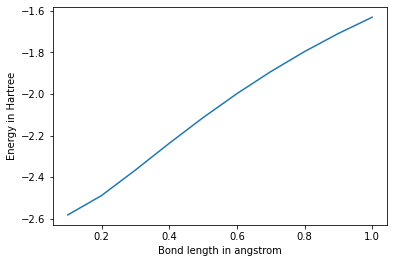

In [39]:
# # Plot.
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(0)
plt.plot(bond_lengths, exact_energies)
#plt.plot(bond_lengths, vqe_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()